# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #3
**Harvard University**<br/>
**Spring 2018**<br/>
**Instructors: Rahul Dave**<br/>
**Due Date: ** Friday, Febrary 16th, 2018 at 10:00am

**Instructions:**

- Upload your final answers as an iPython notebook containing all of your work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Optimization via Descent

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Part A
- Visually verify that for $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is minimized for the given data.
- Implement gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.
- Implement stochastic gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.

### Part B
- Compare the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.
- Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3` (you may wish to set a cap for maximum number of iterations). Which method converges to the optimal point in fewer iterations? Briefly explain why this result should be expected.

### Part C
Compare the performance of stochastic gradient descent for the following learning rates: 1, 0.1, 0.001, 0.0001. Based on your observations, briefly describe the effect of the choice of learning rate on the performance of the algorithm.

****

### Part A

##### i)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
% matplotlib inline

In [2]:
df = pd.read_csv('HW3_data.csv',header=None)

In [3]:
df

,0,1,2,3,4,5,6,7,8,9,...,15990,15991,15992,15993,15994,15995,15996,15997,15998,15999
0,17.218862,20.838999,11.968430,80.804795,83.848662,67.629543,70.819127,69.846960,79.570422,82.935346,...,-99.984459,-94.426439,-16.004488,-19.957821,-87.756765,-59.451012,-91.805088,-97.916107,-49.388900,-56.236041
1,-17.215958,20.836600,11.964252,80.804176,83.848066,-67.628804,-70.818421,69.846244,79.569793,82.934743,...,99.983959,94.425909,16.001363,19.955316,-87.756195,-59.450171,91.804543,-97.915596,49.387887,56.235152


In [4]:
lambda1 = np.linspace(-5,5,100)
lambda2 = np.linspace(-5,5,100)

Lval = np.zeros((lambda1.shape[0],lambda2.shape[0]))

for i in range(len(lambda1)):
    for j in range(len(lambda2)):
        Lval[i,j] = np.sum(0.000045*lambda2[j]**2*df.iloc[1,:] - 0.000098*lambda1[i]**2*df.iloc[0,:] + 0.003926*lambda1[i]*df.iloc[0,:]*np.exp(-0.1*(lambda1[i]**2+lambda2[j]**2)))
        

Text(0,0.5,'$\\lambda_1$')

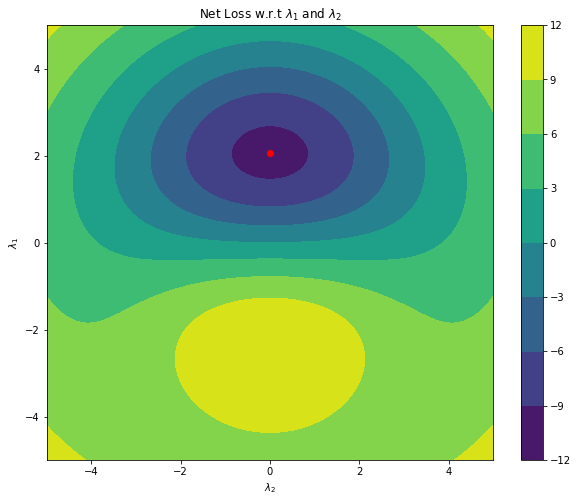

In [5]:
plt.figure(figsize=(10,8))
plt.title(r'Net Loss w.r.t $\lambda_1$ and $\lambda_2$')
plt.contourf(lambda1,lambda2,Lval)
plt.colorbar()
plt.scatter(0,2.05384,c='r')
plt.xlabel(u'$\lambda_2$')
plt.ylabel(u'$\lambda_1$')

##### ii)

To solve this problem we need to determine the gradient of the cost function w.r.t the paramaters. We thus calculate these s.t.:

$$ dL/d\lambda_1 = 0.000196\lambda_1 x + 0.003926xe^{-0.1(\lambda_1^2+\lambda_2^2)} -0.2\lambda_1^2(0.003926)xe^{-0.1(\lambda_1^2+\lambda_2^2)} $$

$$ dL/d\lambda_2 = 0.00009\lambda_2y + 0.003926\lambda_1x(-0.2)\lambda_2e^{-0.1(\lambda_1^2+\lambda_2^2)} $$

#### Note

###### In brief

I noticed that in later parts of the problem we need to make comparisons between GD and SGD. In order to do this well we can take averages of our cost function and averages of our gradient in our implementations. To simplify all this, I essentially create minibatch which encompasses GD and SGD.

I also noticed after implementing these methods that a learning rate of 0.001 is too slow for convergence (when using an averaged gradient) so I make a design decision to increase the learning rate in order to get reasonable convergence.

Furthermore, I also highlight that there are numerous stopping conditions:

1) abs(avgcurrentcost-avgoldcost) > precision

2) abs(avgcurrentcost - avgactualcost(at lambdas provided) ) > precision

3) abs(lambda[0] - 2.05384) and abs(lambda[1] - 0) > precision


For this problem, I choose to use option 3 since we are given the true lambda parameters.

##### in detail
Steps taken to reach the current implementation:
    
1) I implemented both SGD and GD, used the total cost in relation to the actual cost at the specified lambdas as a stopping criterion and ran the methods with lr = 0.001 and starting lambdas of [1,1]. 

Observations:

- within a reasonable number of iterations I manage to converge using GD which is great.
- when I run SGD the lambdas barely change and there is little to no convergence. In fact, when I use a stopping criterion as (currentcost-oldcost) I actually end up converging to the maximum sometimes b/c when I evaluate the gradient at certain points they point in the opposite direction to the total gradient and the surface to the maximum is much smoother.

Given this, it is clear that SGD gradients aren't on the same order of magnitude as that with GD. So, how to make these comparable? One way to do this is to multiply the SGD gradient by the dataset size, or equivalently divide the GD gradient by the datasetsize and keep the gradient update in SGD.

I use the latter which takes me to implementation 2.

2) In this I implemented minibatch (to encompass methods), used the parameters to estimate precision/tolerance as stopping criteria and ran the methods with lr = 0.001, starting lambdas of [1,1].

Observations:

- by averaging, both methods simply don't update so I needed to increase the lr to 0.1/1 to see convergence with both methods.
- plots of the convergence can be seen below.

In [36]:
import time

# total cost
def cost(x,y,l1,l2):
    return np.sum(0.000045*l2**2*y - 0.000098*l1**2*x + 0.003926*l1*x*np.exp(-0.1*(l1**2+l2**2)))

# total gradient
def grad(x,y,l1,l2):
    dldl1 = np.sum(-0.000196*l1*x + 0.003926*x*np.exp(-.1*(l1**2+l2**2)) -.2*(l1**2)*(0.003926)*x*np.exp(-.1*(l1**2+l2**2)))
    dldl2 = np.sum(0.00009*l2*y + 0.003926*l1*x*(-.2)*l2*np.exp(-.1*(l1**2+l2**2)))
    return( np.array([dldl1,dldl2]))

# some global variables
m = df.iloc[0,:].shape[0]
actual_lamb = np.array([2.05384,0])

# helps get indices of batch size
def get_ids(batch_size,vec_length):
    f = np.floor(vec_length/batch_size).astype(int)
    diff = vec_length - f*batch_size
    arr = []
    for i in range(f):
        arr.append([(i)*batch_size,(i+1)*batch_size])
    if diff != 0:
        arr.append([f*batch_size,f*batch_size+diff])
    return(arr)

# define minibatch
def minibatch(x, y, lamb_init,batch_size, step=1, maxsteps=10000, precision=10**(-3)):   
    tsgd = []
    hist = []
    costs = []
    bs = batch_size
    lamb = lamb_init
    counter = 0
    splitter = get_ids(bs,m)
    firstorder = np.random.permutation(m)
    epoch = 0 
    x = x[firstorder]
    y = y[firstorder]
    idx = 0
    splitlen = len(splitter)
    
    while np.linalg.norm(lamb-actual_lamb) > precision:
        a = time.clock()
        # divs for different scaling factors
        if div == 0:
            gradient = grad(x[splitter[idx][0]:splitter[idx][1]],y[splitter[idx][0]:splitter[idx][1]],lamb[0],lamb[1])/(bs)
        elif div == 1:
            gradient = grad(x[splitter[idx][0]:splitter[idx][1]],y[splitter[idx][0]:splitter[idx][1]],lamb[0],lamb[1])/np.sqrt(bs)
        else:
            gradient = grad(x[splitter[idx][0]:splitter[idx][1]],y[splitter[idx][0]:splitter[idx][1]],lamb[0],lamb[1])*(m)/(bs)
        lamb = lamb - step*gradient  # update
        hist.append(lamb)
        costs.append(cost(df.iloc[0,:],df.iloc[1,:],lamb[0],lamb[1]))
        counter+=1
        idx+=1
        if (splitlen) == 1:
            idx = 0
        if idx == (splitlen):#reached one past the end.
            #break
            epoch +=1
            neworder = np.random.permutation(m)
            x = x[neworder]
            y = y[neworder]
            idx = 0
        tsgd.append(time.clock()-a)
        
        if counter == maxsteps:
            break
    return(lamb,tsgd,hist,costs)




In [7]:
# plotting function
def make_3d_plot(xfinal, yfinal, zfinal, hist, costv):
    ms = np.linspace(xfinal - 2 , xfinal + 2, 20)
    bs = np.linspace(yfinal - 2 , yfinal + 2, 20)
    zs = np.zeros((len(ms),len(bs)))
    M, B = np.meshgrid(ms, bs)
    for i in range(len(ms)):
        for j in range(len(bs)):
            zs[i,j] =cost(df.iloc[0,:],df.iloc[1,:],ms[i],bs[j])
    Z = zs.reshape(M.shape)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.1)
    ax.contour(M, B, Z, 20, alpha=0.5, offset=0, stride=30)
    ax.set_xlabel(r'$\lambda_1$')
    ax.set_ylabel(r'$\lambda_2$')
    ax.set_zlabel('Cost')
    ax.view_init(elev=30., azim=30)
    ax.plot([xfinal], [yfinal], [zfinal] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);
    ax.plot([t[0] for t in hist], [t[1] for t in hist], costv , markerfacecolor='b', markeredgecolor='b', marker='.', markersize=5);
    ax.plot([t[0] for t in hist], [t[1] for t in hist], 0 , alpha=0.5, markerfacecolor='r', markeredgecolor='r', marker='.', markersize=5)
    
def gd_plot(theta, cost, hist):
    make_3d_plot(theta[0], theta[1], cost[-1], hist, cost)

#### Divide GD gradient by size of dataset

In [42]:
# div = 0 means divide by dataset size
div = 0
lgd1,tgd1,hisgd1,costgd1 = minibatch(df.iloc[0,:],df.iloc[1,:],np.array([1,1]),m)
lsgd1,tsgd1,hissgd1,costsgd1 = minibatch(df.iloc[0,:],df.iloc[1,:],np.array([1,1]),1)

Text(0.5,0.92,'Stochastic Gradient Descent')

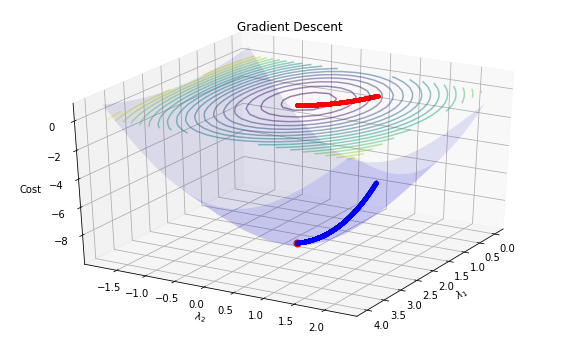

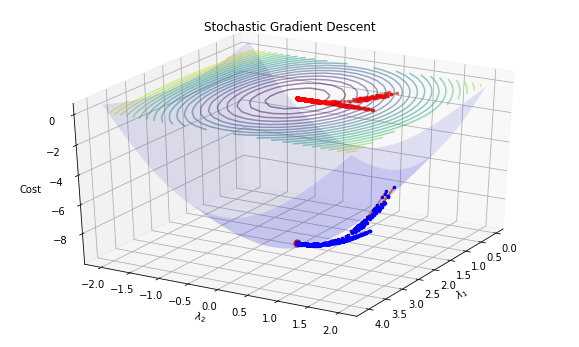

In [53]:
gd_plot(hisgd1[-1],costgd1,hisgd1)
plt.title('Gradient Descent')
gd_plot(hissgd1[-1],costsgd1,hissgd1)
plt.title('Stochastic Gradient Descent')

#### Divide GD gradient by sqrt(size of dataset)

Text(0.5,0.92,'Stochastic Gradient Descent')

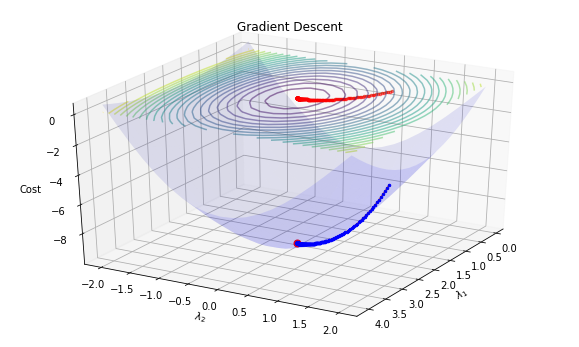

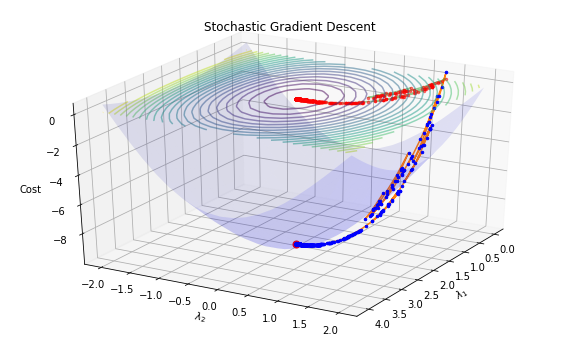

In [54]:
div = 1
lgd2,tgd2,hisgd2,costgd2 = minibatch(df.iloc[0,:],df.iloc[1,:],np.array([1,1]),m)
lsgd2,tsgd2,hissgd2,costsgd2 = minibatch(df.iloc[0,:],df.iloc[1,:],np.array([1,1]),1)
gd_plot(hisgd2[-1],costgd2,hisgd2)
plt.title('Gradient Descent')
gd_plot(hissgd2[-1],costsgd2,hissgd2)
plt.title('Stochastic Gradient Descent')

Observations
- SGD behaves quite randomly in its motion to the minimum (goes up quite often)
- SGD is quite sensitive to the specific learning rate (it can launch off into random directions quite quickly if the learning rate is large)
- If we divide the GD gradient by the dataset size, we get a gradient that is significantly smaller than the point gradient on avg - to account for this,
we can divide by sqrt(dataset size) which gives us comparable convergence times.


#### Part B

###### Dividing GD by dataset size

In [55]:
print('Total time to converge with SGD = %s'%(np.sum(tsgd1)))
print('Total time to converge with GD = %s'%(np.sum(tgd1)))

Total time to converge with SGD = 17.883050458383877
Total time to converge with GD = 52.00642749618237


In [56]:
print('Average time to update params with SGD = %s'%(np.mean(tsgd1)))
print('Average time to update params with GD = %s'%(np.mean(tgd1)))

Average time to update params with SGD = 0.004436380664446509
Average time to update params with GD = 0.0052006427496182365


In [57]:
print('Total # of iterations to converge with SGD = %s'%(len(tsgd1)))
print('Total # of iterations to converge with GD = %s'%(len(tgd1)))

Total # of iterations to converge with SGD = 4031
Total # of iterations to converge with GD = 10000


In [58]:
print('Time for 100 iterations with SGD = %s'%(np.sum(tsgd1[0:100])))
print('Time for 100 iterations  with GD = %s'%(np.sum(tgd1[0:100])))

Time for 100 iterations with SGD = 0.4360993405721274
Time for 100 iterations  with GD = 0.5532720885198614


When we divide by the dataset size, the averaged gradient is much lower with GD than it is with SGD. As a result, with the same learning rate we see that GD takes longer to converge since its steps are significantly smaller. Note that an individual update of the parameters takes less time with SGD than with GD and that is expected since we end up doing fewer total operations. However, per epoch, SGD is computationally more expensive since there is a large overhead of simply iterating over all the individual samples. It remains unclear if SGD would perform better if the for loop were embedded in numpy.


###### Dividing GD by sqrt(dataset size)

In [59]:
print('Total time to converge with SGD = %s'%(np.sum(tsgd2)))
print('Total time to converge with GD = %s'%(np.sum(tgd2)))

Total time to converge with SGD = 8.291850923545098
Total time to converge with GD = 1.9957068923490624


This makes sense in that the random walker hops around before he converges so it will take in general longer to get to the optima given this loss function if the gradients are similar which is why I look at sqrt(datasetsize) because it seems to reflect a stronger comparison.Note: If the gradient of GD is divided by dataset size instead of root(datasetsize) the convergence of GD is slower since the gradient is reduced significantly.

In [60]:
print('Average time to update with SGD = %s'%(np.mean(tsgd2)))
print('Average time to update with GD = %s'%(np.mean(tgd2)))

Average time to update with SGD = 0.0056522501182993175
Average time to update with GD = 0.005767938995228504


In [61]:
print('Total # of iterations to converge with SGD = %s'%(len(tsgd2)))
print('Total # of iterations to converge with GD = %s'%(len(tgd2)))

Total # of iterations to converge with SGD = 1467
Total # of iterations to converge with GD = 346


In [62]:
print('Time for 100 iterations with SGD = %s'%(np.sum(tsgd2[0:100])))
print('Time for 100 iterations  with GD = %s'%(np.sum(tgd2[0:100])))

Time for 100 iterations with SGD = 0.5827596554336196
Time for 100 iterations  with GD = 0.5906427531449481


Note: Iterations here refer to a single update of the parameters. So in SGD it means an update after 1 sample.

###### iii)

In [74]:
div = 0
lrs = [1,0.1,0.001,0.0001]
data1 = []
data2 = []
for i in range(4):
    lsgd1,tsgd1,hissgd1,costsgd1 = minibatch(df.iloc[0,:],df.iloc[1,:],np.array([1,1]),1,step=lrs[i])
    data1.append(lsgd1)
    data2.append(tsgd1)

In [75]:
for i in range(4):
    print('Number of iterations when lrs = ' +str(lrs[i]) + ' is ' + str(len(data2[i])))

Number of iterations when lrs = 1 is 3023
Number of iterations when lrs = 0.1 is 10000
Number of iterations when lrs = 0.001 is 10000
Number of iterations when lrs = 0.0001 is 10000


In [76]:
for i in range(4):
    print('Time to converge when lrs = ' +str(lrs[i]) + ' is ' + str(np.sum(data2[i])))

Time to converge when lrs = 1 is 14.867729265235539
Time to converge when lrs = 0.1 is 60.03909249171102
Time to converge when lrs = 0.001 is 54.70409257454776
Time to converge when lrs = 0.0001 is 48.91977548195882


The limit was set to 10,000 iterations and we can see that once the learning rate is reduced from 1 down to 0.1 we already hit that when we use an unscaled SGD gradient (essentially the update is not scaled by the dataset size).

If we scale the gradient by the dataset size then the first 2 learning rates don't even converge to the right values because the gradient is too large. The last two allow for good convergence. In the end it all depends on how we want to 'compare' things and what we mean by comparison in the case. 

The main thing to note is that there probably exists some optimal learning rate that is fast enough to converge without scaling the gradient too much to send it off the global minima.

## Problem 2. SGD for Multinomial Logistic Regresion on MNIST

The [*MNIST* dataset](https://en.wikipedia.org/wiki/MNIST_database) is one of the classic datasets in Machine Learning and is often one of the first datasets against which new classification algorithms test themselves.  It consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. You will be using PyTorch to build a handwritten digit classifier that you will train and test with MNIST. 

** The MNIST dataset (including a train/test split which you must use) is part of PyTorch in the torchvision module.  The Lab will have details of how to load it. **

Your classifier must implement a multinomial logistic regression model (using softmax). It will take as input an array of pixel values in an image and output the images most likely digit label (i.e. 0-9). You should think of the pixel values as features of the input vector.  

1. Plot 10 sample images from the MNIST dataset (to develop intuition for the feature space).
2. Construct a softmax formulation in PyTorch of multinomial logistic regression with Cross Entropy Loss.
3. Train your model using SGD to minimize the cost function. *Use a batch size of 64, a learning rate $\eta = 0.01$, and 10 epochs*.
4. Plot the cross-entropy loss on the training set as a function of iteration.
5. What are the training and test set accuracies?  
6. Plot some (around 5) examples of misclassifications.




In [107]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [108]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])
train= dset.MNIST(root='processed/',train=True,transform=transform,download=True)
test = dset.MNIST(root='processed/',train=False,transform=transform,download=True)
trainloader = torch.utils.data.DataLoader(train, batch_size=64,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=64,shuffle=False, num_workers=2)

In [195]:
def imshow(img):
    img = img*0.3081+0.1307
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images[0:10]
label = labels[0:10]

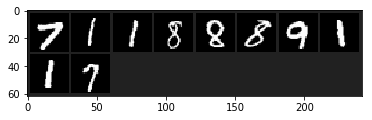

In [110]:
imshow(torchvision.utils.make_grid(images))

In [113]:
print('labels'+' '.join('%5s' % labels[j] for j in range(10)))

labels    7     1     1     8     8     8     9     1     1     7


In [49]:
class Model(torch.nn.Module):

    def __init__(self):
        """
        In the constructor we instantiate two nn.Linear module
        """
        super(Model, self).__init__()
        # takes in the flattened image and outputs 10 linear functions
        self.linear = torch.nn.Linear(784, 10)  # One in and one out

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        # simply predict(I could have had softmax as another layer but I chose to use nn.crossentropyloss which has that built-in)
        y_pred = self.linear(x)
        
        return y_pred

# our model
model = Model()


# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


stored_loss = []
# Training loop
for epoch in range(10):
    for i, (images,labels) in enumerate(trainloader):
        i
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(Variable(images.view(images.shape[0],-1)))

        # Compute and print loss
        loss = criterion(y_pred, Variable(labels))
        
        stored_loss.append(loss.data[0])

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

Text(0.5,1,'Cross Entropy Loss vs Iterations')

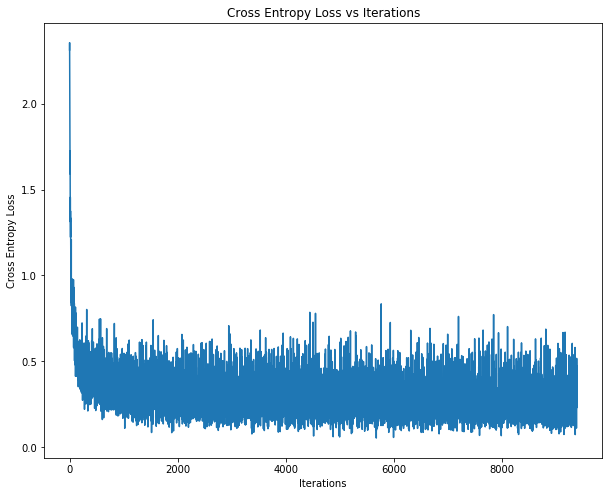

In [106]:
plt.figure(figsize=(10,8))
plt.plot(stored)
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.title('Cross Entropy Loss vs Iterations')

#### Training and test accuracy

In [94]:
# Training Accuracy
a = nn.Softmax(dim=1)
count_true = 0
count_false = 0
# predict in batches (since this is how our data is)
for i, (images,labels) in enumerate(trainloader):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(Variable(images.view(images.shape[0],-1)))
    vals,idxs = torch.max(a(y_pred),dim=1)
    preds = idxs.data.numpy()
    lbs = labels.numpy()
    count_true += np.sum(preds==lbs)
    count_false += np.sum(preds!=lbs)

In [114]:
print('The training accuracy rate = %s' %((1-count_false/(count_true+count_false))*100) + '%')

The training accuracy rate = 92.03%


In [204]:
# Training Accuracy
a = nn.Softmax(dim=1)
count_true = 0
count_false = 0
mis_img = []
mis_preds = []
mis_lbl = []
jj = 0
# predict in batches (since this is how our data is)
for i, (images,labels) in enumerate(testloader):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(Variable(images.view(images.shape[0],-1)))
    vals,idxs = torch.max(a(y_pred),dim=1)
    preds = idxs.data.numpy()
    lbs = labels.numpy()
    tfs = preds==lbs
    count_true += np.sum(preds==lbs)
    count_false += np.sum(preds!=lbs)
  
    if jj == 0:
        print(np.where(tfs==False)[0].tolist())
        jj=1
    # indexing images misclassified
    ids = np.where(tfs==False)[0]
    if (ids.size != 0):
        mis_img.append(images[ids.tolist()])
        mis_lbl.append(lbs[ids])
        mis_preds.append(preds[ids])

[8, 33, 63]


In [170]:
print('The test accuracy rate = %s' %np.round((1-count_false/(count_true+count_false))*100,3) + '%')

The test accuracy rate = 92.03%


#### Plots of misclassifications 

In [205]:
mis_img[6].shape

torch.Size([5, 1, 28, 28])

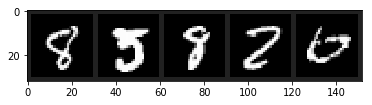

In [206]:
imshow(torchvision.utils.make_grid(mis_img[6]))

In [209]:
print('actual labels'+' '.join('%5s' % mis_lbl[6][j] for j in range(5)))
print('predicted labels'+' '.join('%5s' % mis_preds[6][j] for j in range(5)))


actual labels    8     5     8     2     6
predicted labels    5     3     7     8     0
